Name: Josemaria Macedo Carrillo\
Ttile: Land Matrix Data Exploration\
Created: 08/07/23\
Last modified:
DSI

The purpose of this notebook is to analyze data on Ukrainian agricultural
exports for October 2022 (busiest month according to BSGI). The main data sources
are the Black Sea Grain Initiative (BSGI) of the United
Nations and Import Genius (IG), a website that has trade data for different countries
including Ukraine.

In [1]:
import sys
sys.path.append('..')
import pandas as pd
from utils.get_data import get_data, import_data
from utils.record_linkage import rl_ig_bsgi
from utils.plot import cargo_grouping, plot_line, plot_crops, plot_pie, plot_stack_bar
from utils.clean_data import PRODUCTS_VAL, translate_column, rename_columns, create_columns, clean_column
from utils.transform_data import estimate_weights, standard_company_name, create_wide_table
from utils.record_linkage import record_linkage, unique_matches, filter_crop, find_matches
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator
import numpy as np

Import cleaned data from Import Genius (IG) and the Black Sea Grain Initiative
(BSGI) with all the necessary columns for further analysis.

In [2]:
ig = get_data("ig")
bsgi = get_data("bsgi")

In [3]:
print("Country names IG:\n", ig["country"].unique())
print("Country names BSGI:\n", bsgi["country_en"].unique())

Country names IG:
 ['іспанія' 'нідерланди' 'угорщина' 'індонезія' 'алжир' 'італія'
 'бангладеш' 'словаччина' 'польща' 'молдова' 'азербайджан'
 'сполучене королівство' 'вірменія' 'казахстан' 'грузія' 'киргизстан'
 'румунія' 'чеська республіка' 'сполучені штати америки' 'швейцарія'
 'узбекистан' 'німеччина' 'македонія колишня югославська республіка'
 'ізраїль' 'уганда' 'кувейт' 'хорватія' 'болгарія'
 "об'єднані арабські емірати" 'єгипет' 'лівійська арабська джамахірія'
 'бельгія' 'малайзія' 'франція' 'корея республіка' 'кенія' 'туреччина'
 'туніс' 'китай' 'ірак' 'пакистан' 'оман' 'сенегал' 'норвегія' 'йорданія'
 'таїланд' 'латвія' 'бахрейн' 'коста-ріка' 'литва' 'швеція' 'індія'
 'палестинська територія' 'мальта' 'ліван' 'гваделупа (фр)' 'коста ріка'
 'габон' 'канада' 'сурінам' 'об єднані арабські емірати' 'кот д івуар'
 'гайана' 'саудівська аравія' 'тайвань провінція китаю' 'перу' 'гана'
 'гвінея' 'ємен' 'м янма' 'нова каледонія' 'об єднана республіка танзанія'
 'мадагаскар' 'маврікій' '

In [4]:
ig_oct = ig.loc[(ig.loc[:, "date"] >= "2022-10-01") & (ig.loc[:, "date"] < "2022-11-01")]
bsgi_oct = bsgi.loc[(bsgi.loc[:, "date"] >= "2022-10-01") & (bsgi.loc[:, "date"] < "2022-11-01")]

We group our data to plot a time series for Kernel, one of the top 10 Ukrainian
agricultural landholders with data from IG. The data is just for October 2022
because it was the most we could export for now with our
subscription and that month was the busiest exports month according to BSGI.
The horizontal axis has the export date in mm-yyyy and the
vertical axis has the total exports volume in metric tons (1,000 kilograms).

We see that there is a shift in the trend of exports in February 2022, when
Russia invaded Ukraine. This makes sense because all Black Sea ports that these
agricultural companies used where closed until the BSGI was signed in July 27,
2022. We can see there was an increase in exports but not as much as in the past.
This could be due to the lack of ports to export (only 3 ports can export at
the Black Sea and a lot of companies have to use the same ports).

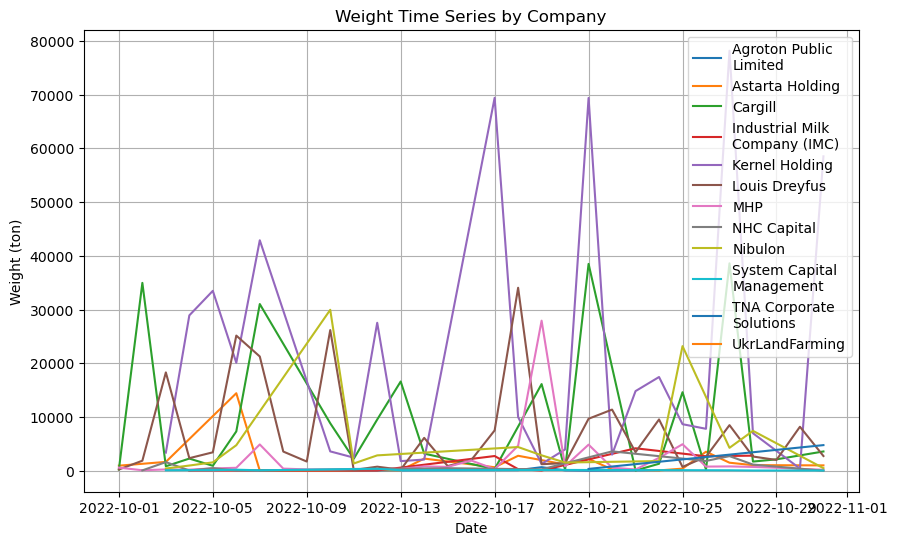

In [5]:
ig_oct_g = cargo_grouping(ig_oct, ["parent_company", "date"], ["weight_ton"], ["date"], True, {"weight_ton": "sum"})
ig_oct_g

# Group by "company_searched"
grouped = ig_oct_g.groupby('parent_company')

# Plot each group as a separate line
plt.figure(figsize=(10, 6))

for name, group in grouped:
    plt.plot(group['date'], group['weight_ton'], label=name)

plt.xlabel('Date')
plt.ylabel('Weight (ton)')
plt.title('Weight Time Series by Company')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [6]:
ig_oct.loc[(ig_oct.loc[:, "company_searched"] == "kernel") & (ig_oct.loc[:, "country"] == "німеччина")][["product", "company_searched", "date", "weight_ton", "country"]]
# oct.loc[(oct.loc[:, "company_searched"] == "kernel")][["product", "company_searched", "date", "weight_ton", "country"]]

,product,company_searched,date,weight_ton,country
2170,кукурудза: - інша,kernel,2022-10-17,909.0,німеччина


In [7]:
bsgi.loc[(bsgi.loc[:, "country_en"] == "germany") & (bsgi.loc[:, "date"] >= "2022-10-01") & (bsgi.loc[:, "date"] < "2022-11-01")][["product", "date", "weight_ton", "country_en"]]
# bsgi.columns

,product,date,weight_ton,country_en
673,corn,2022-10-31,49000,germany
776,rapeseed,2022-10-13,30817,germany
844,corn,2022-10-04,38000,germany


In [8]:
ig_sunflower = filter_crop(ig_oct, "sunflower", "ig")
bsgi_sunflower = filter_crop(bsgi_oct, "sunflower", "bsgi")
ig_sunflower_g = cargo_grouping(ig_sunflower, ["date", "country", "company_searched"], ["weight_ton"],  ["date", "country"], True, {"weight_ton":"sum"})
ig_sunflower_g.sort_values(by=["date"], ascending=True).head(50)[["company_searched", "date", "weight_ton", "country"]]
ig_sunflower_g["weight_ton"].sum()

213307.00741999998

In [9]:
bsgi_sunflower.sort_values(by=["date"], ascending=True)[["product", "date", "weight_ton", "country_en", "departure_port"]]
bsgi_sunflower["weight_ton"].sum()

610934

We estimate the shares of total exports by company.

bsgi_weight:  4241809
ig_weight:  1191434.89292
Values passed to ax.pie:
 12    3.050374e+06
4     5.159455e+05
2     2.352917e+05
5     2.198016e+05
8     8.784659e+04
6     6.252277e+04
1     3.623030e+04
3     1.288057e+04
7     1.236582e+04
10    5.115967e+03
9     1.497040e+03
0     1.178965e+03
11    7.580190e+02
Name: weight_ton, dtype: float64


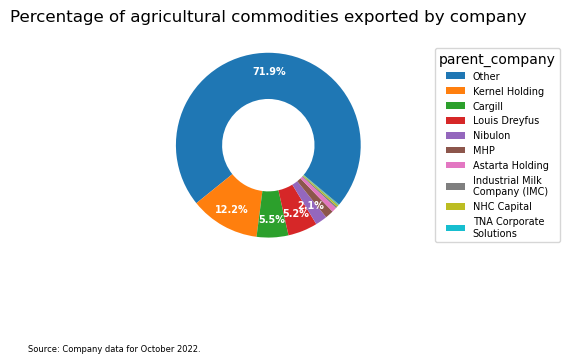

,parent_company,weight_ton
12,Other,3.050374e+06
4,Kernel Holding,5.159455e+05
2,Cargill,2.352917e+05
5,Louis Dreyfus,2.198016e+05
8,Nibulon,8.784659e+04
6,MHP,6.252277e+04
1,Astarta Holding,3.623030e+04
3,Industrial Milk \nCompany (IMC),1.288057e+04
7,NHC Capital,1.236582e+04
10,TNA Corporate \nSolutions,5.115967e+03


In [10]:
estimate_weights(ig_oct, "parent_company", "weight_ton", bsgi_oct, "weight_ton", "Percentage of agricultural commodities exported by company", crop=None)

Now we estimate the shares of exports by company for all countries included in Import Genius that get exports from Ukraine.

bsgi_weight:  82000
ig_weight:  41346.619
Values passed to ax.pie:
 0    41346.619
1    40653.381
Name: weight_ton, dtype: float64


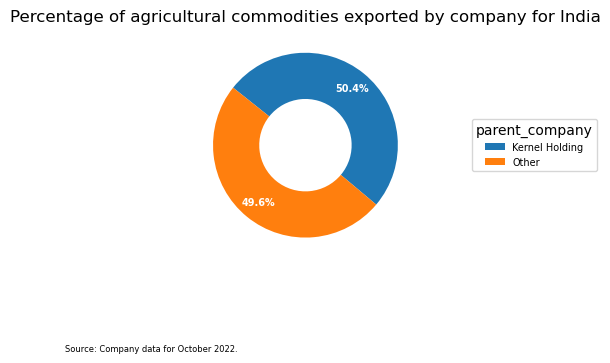

bsgi_weight:  116789
ig_weight:  0.0
Values passed to ax.pie:
 0    116789.0
Name: weight_ton, dtype: float64


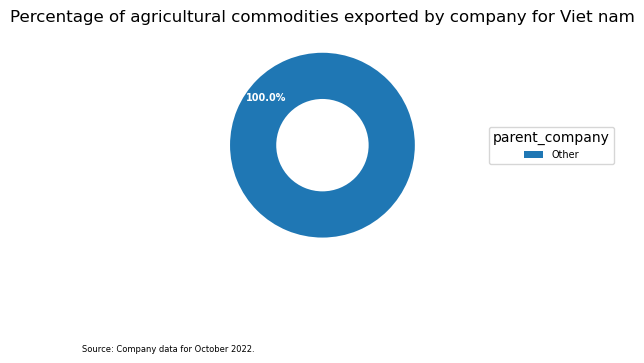

In [11]:
# First we create a dictionary with the country names in English and lowercase as
# keys (for BSGI) and the country names in ukrainian and lowercase as values (for IG)
# country_d = {"india": "індія", "viet nam": "в єтнам", "sri lanka": "шрі ланка"}
country_d = {"india": "індія", "viet nam": "в єтнам"}

for country_en, country_uk in country_d.items():
    ig_country = ig_oct.loc[ig_oct.loc[:, "country"] == country_uk]
    bsgi_country = bsgi_oct.loc[bsgi_oct.loc[:, "country_en"] == country_en]
    estimate_weights(ig_country, "parent_company", "weight_ton", bsgi_country, "weight_ton", f"Percentage of agricultural commodities exported by company for {country_en.capitalize()}", crop=None)

In [12]:
# Check who's exporting to Vietnam in October 2022 (IG)
ig_vietnam = ig_oct.loc[ig_oct.loc[:, "country"] == "в єтнам"]
ig_vietnam
bsgi_vietnam = bsgi_oct.loc[bsgi_oct.loc[:, "country_en"] == "viet nam"]
bsgi_vietnam

,status,,vessel_name,imo,departure_port,country_en,product,weight_ton,date,inspection_cleared,...,un_region,development_category,wfp,stranded,year,month,product_std,hs_code,product_std_gt,country
717,Outbound,381,C FAITH,9575163,Odesa,viet nam,wheat,56789,2022-10-24,31-Oct-2022,...,Asia-Pacific,developing,NaN,NaN,2022,10,wheat,1001,пшениця,в'єтнам
819,Outbound,287,CORNELIA M,9490117,Yuzhny/Pivdennyi,viet nam,wheat,60000,2022-10-08,31-Oct-2022,...,Asia-Pacific,developing,NaN,NaN,2022,10,wheat,1001,пшениця,в'єтнам


Now we estimate the shares for all countries included in IG (India and Vietnam)

bsgi_weight:  198789
ig_weight:  41346.619
Values passed to ax.pie:
 1    157442.381
0     41346.619
Name: weight_ton, dtype: float64


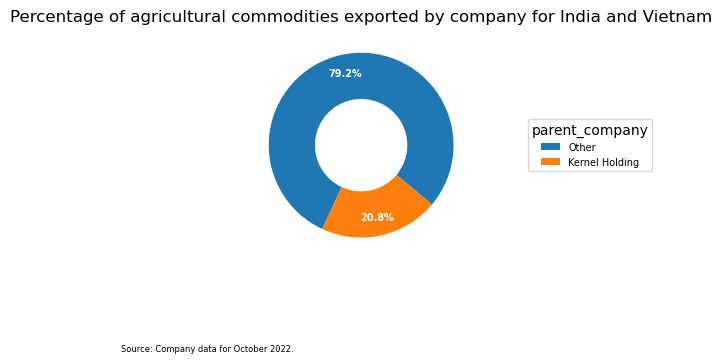

,parent_company,weight_ton
1,Other,157442.381
0,Kernel Holding,41346.619


In [13]:
ig_country = ig_oct.loc[(ig_oct.loc[:, "country"] == "індія") | (ig_oct.loc[:, "country"] == "в єтнам")]
bsgi_country = bsgi_oct.loc[(bsgi_oct.loc[:, "country_en"] == "india") | (bsgi_oct.loc[:, "country_en"] == "viet nam")]
estimate_weights(ig_country, "parent_company", "weight_ton", bsgi_country, "weight_ton", f"Percentage of agricultural commodities exported by company for India and Vietnam", crop=None)

Now we estimate the shares of exports for India, Vietnam and Sri Lanka from August 2022 (beginning of BSGI) until March 2023 (end of IG) for all companies.

In [14]:
# First we import the csv file
ig_asia = import_data("/Users/jmacedoc/Documents/DSI/Ukraine Agricultural Exports/oakland-institute-ukraine/data/ig_all_22-23.csv", "ig")
ig_asia["company_searched"] = ig_asia["SHIPPER"]
ig_asia = rename_columns(ig_asia, "ig")

ig_asia["year"] = ig_asia["date"].dt.year
ig_asia["month"] = ig_asia["date"].dt.month

ig_asia["weight_ton"] = ig_asia["weight_kg"] / 1000
product_std = set(PRODUCTS_VAL)
# We create a variable that sums the number of products mentioned in the
# product name
ig_asia["n_products"] = 0
for product in product_std:
    product_uk = GoogleTranslator("en", "uk").translate(product)
    ig_asia[product] = ig_asia["product"].apply(lambda x: True if product_uk in x.lower() else False)
    ig_asia["n_products"] += ig_asia[product]

columns = ["country", "product"]
for col in columns:
    clean_column(ig_asia, col)

In [15]:
ig_asia["country"].unique()

array(["в'єтнам", 'індія', 'шрі-ланка', 'в єтнам', 'шрі ланка'],
      dtype=object)

We transform the country strings to the correct ones manually. This should be done
after doing record linkage but since we're not doing that we'll do it manually and then add it to
a function.

In [16]:
correct_name = {"в'єтнам": "в єтнам", "в єтнам": "в єтнам", "індія": "індія", "шрі-ланка": "шрі ланка", "шрі ланка": "шрі ланка"}
ig_asia["country"] = ig_asia["country"].apply(lambda x: correct_name[x])
ig_asia.columns

Index(['product', 'hs_code', 'consignee', 'consignee_address', 'shipper',
       'shipper_address', 'date', 'quantity', 'weight_kg', 'invoice_price_uah',
       'total_invoice_value_usd', 'invoice_price_in_kilograms_usd',
       'item_unit', 'item_number', 'customs_value', 'customs_office_code',
       'country_of_origin', 'country', 'place_of_delivery', 'delivery_terms',
       'declaration_no', 'currency_ratio', 'sender_code', 'bank_name',
       'company_searched', 'year', 'month', 'weight_ton', 'n_products',
       'sunflower', 'mixed', 'peas', 'soya', 'wheat', 'barley', 'sugar beet',
       'rapeseed', 'vegetable', 'canola', 'corn'],
      dtype='object')

Now we filter just exports for crops that are included in BSGI so we can compare the volumes (otherwise we'll include exports for other commodities like metals that are included in IG but that aren't included in BSGI)

In [17]:
HS_DICT = {"1205": "Rapeseed", "2306": "Rapeseed meal", "1514": "Canola",
           "1005": "Corn", "1512": "Sunflower oil", "1206": "Sunflower seed",
            "2306": "Sunflower pellets", "2306": "Sunflower meal",
          "1001":  "Wheat", "1201": "Soya beans", "1507": "Soya oil",
          "1003":  "Barley", "0713": "Peas", "1516": "Vegetable oil",
           "2302": "Wheat bran pellets", "2302": "Sugar beet pellets"}

ig_asia["hs_code_2"] = ig_asia["hs_code"].str[:4]

ig_asia["bsgi_commodity"] = ig_asia["hs_code_2"].apply(lambda x: HS_DICT[x] if x in HS_DICT else "Not in BSGI")

ig_asia = ig_asia[ig_asia["bsgi_commodity"]!= "Not in BSGI"]

print("IG tons:",ig_asia.loc[ig_asia.loc[:, "country"] == "в єтнам"]["weight_ton"].sum())
print("BSGI tons:",bsgi.loc[bsgi.loc[:, "country_en"] == "viet nam"]["weight_ton"].sum())

IG tons: 174997.27360000001
BSGI tons: 168789


We filter the BSGI data to include only months that are included in our IG data (August 2022 until March 2023)

In [18]:
bsgi_asia = bsgi[(bsgi["date"] >= "2022-08-01") & (bsgi["date"] < "2023-04-01")]

Now we estimate the export shares by country

bsgi_weight:  454286
ig_weight:  405719.77599999995
Values passed to ax.pie:
 28     58324.200
113    48566.224
36     48000.000
39     42895.420
5      23874.420
         ...    
41        30.230
38        24.840
3         22.760
66        19.400
79        19.200
Name: weight_ton, Length: 114, dtype: float64


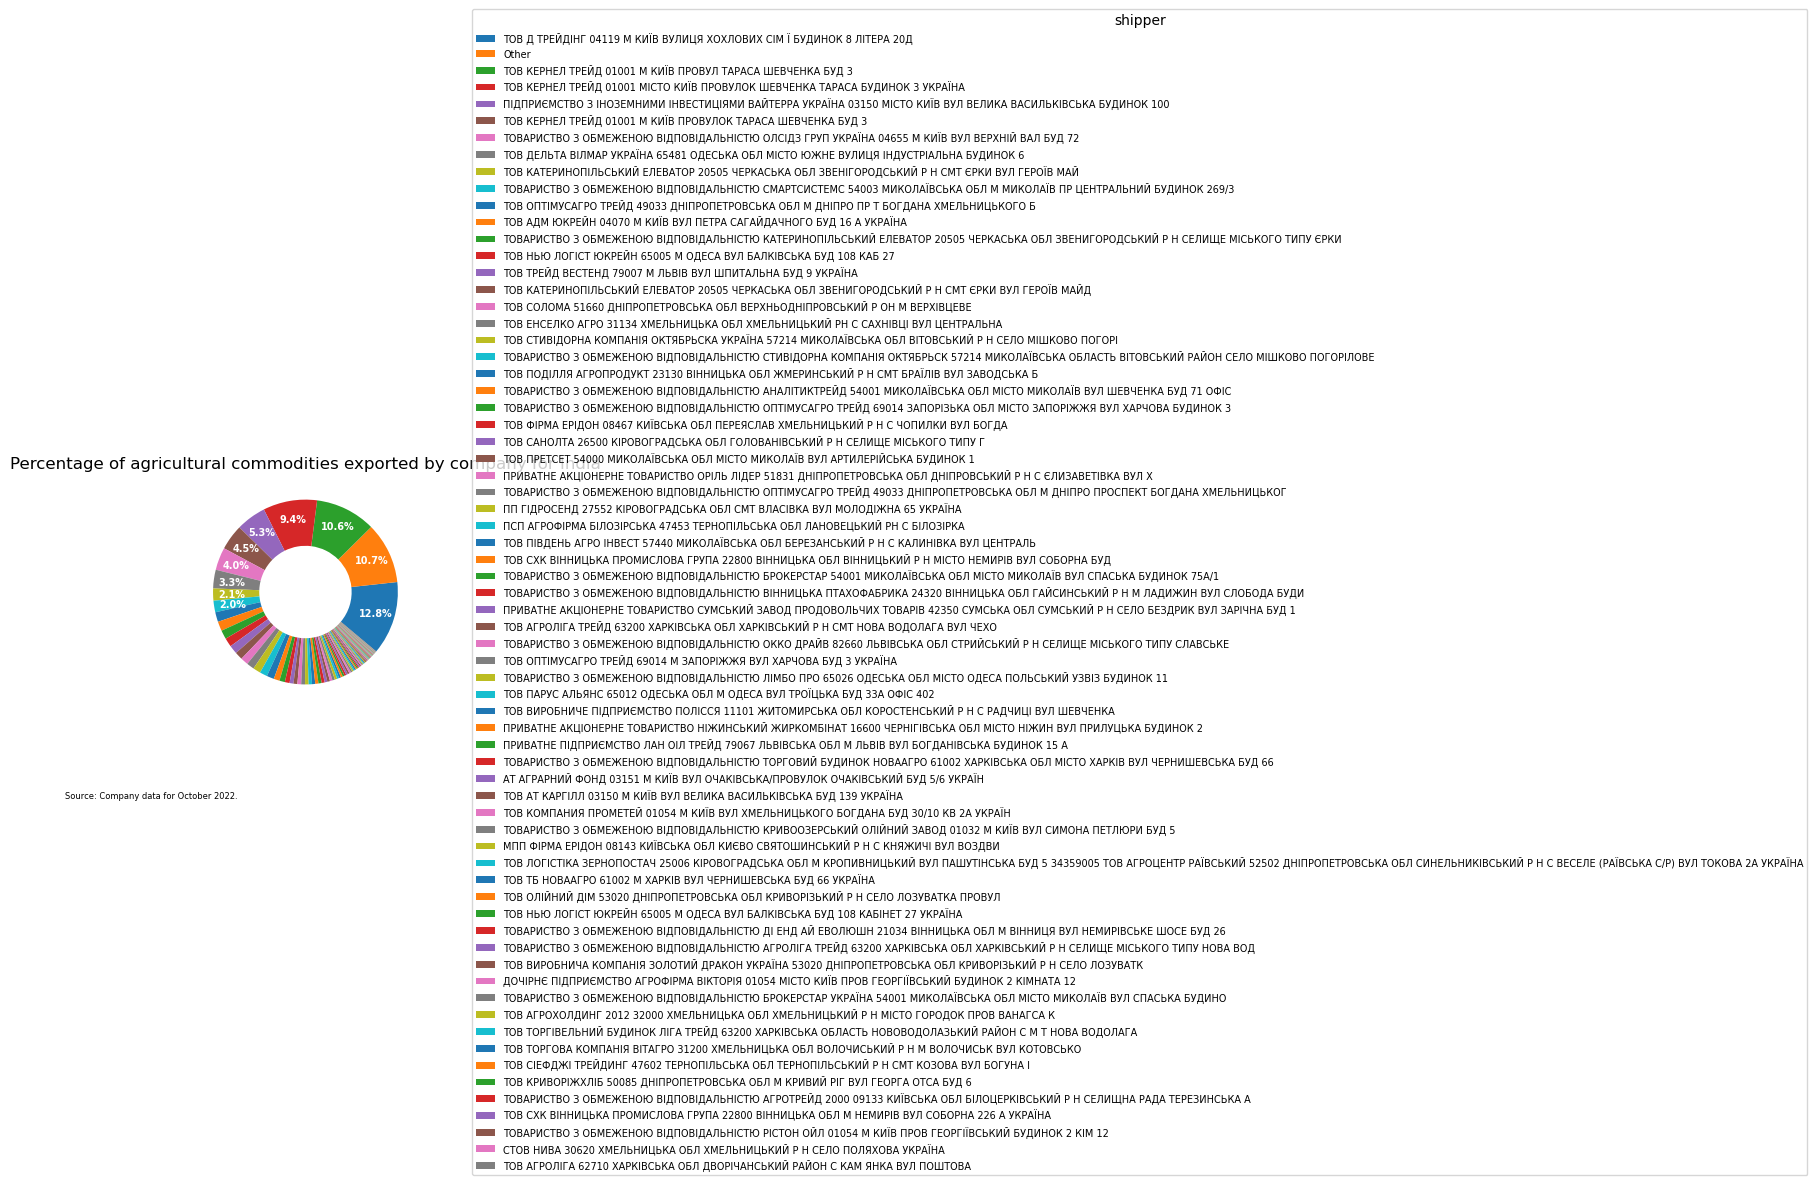

bsgi_weight:  168789
ig_weight:  174997.27360000001
Values passed to ax.pie:
 20    21447.1000
30    21151.7900
26    12001.5400
41    10457.4910
2      8742.4300
         ...    
47       25.4290
48       24.4110
56       24.3500
0        23.5000
86    -6208.2736
Name: weight_ton, Length: 87, dtype: float64


ValueError: Wedge sizes 'x' must be non negative values

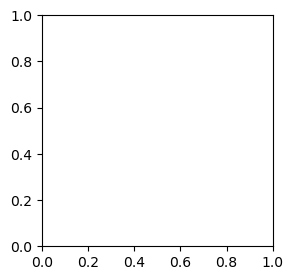

In [19]:
country_d = {"india": "індія", "viet nam": "в єтнам", "sri lanka": "шрі ланка"}

for country_en, country_uk in country_d.items():
    ig_country = ig_asia.loc[ig_asia.loc[:, "country"] == country_uk]
    bsgi_country = bsgi_asia.loc[bsgi_asia.loc[:, "country_en"] == country_en]
    df = estimate_weights(ig_country, "shipper", "weight_ton", bsgi_country, "weight_ton", f"Percentage of agricultural commodities exported by company for {country_en.capitalize()}", crop=None)

In [20]:
df

,shipper,weight_ton
28,ТОВ Д ТРЕЙДІНГ 04119 М КИЇВ ВУЛИЦЯ ХОХЛОВИХ СІ...,58324.200
113,Other,48566.224
36,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛ ТАРАСА ШЕ...,48000.000
39,ТОВ КЕРНЕЛ ТРЕЙД 01001 МІСТО КИЇВ ПРОВУЛОК ШЕВ...,42895.420
5,ПІДПРИЄМСТВО З ІНОЗЕМНИМИ ІНВЕСТИЦІЯМИ ВАЙТЕРР...,23874.420
...,...,...
41,ТОВ КОМОРІТІ 65080 ОДЕСЬКА ОБЛ М ОДЕСА ЛЮСТДОР...,30.230
38,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛОК ШЕВЧЕНК...,24.840
3,ДОЧІРНЄ ПІДПРИЄМСТВО З ІНОЗЕМНОЮ ІНВЕСТИЦІЄЮ С...,22.760
66,ТОВ СІЛЬВЕР 777 65114 УКРАЇНА 65114 ОДЕСЬКА ОБ...,19.400


We have to create a column with standardized company names.

In [21]:
known_companies = {"Kernel": ["ДРУЖБА НОВА", "ЕНСЕЛКО АГРО", "ПОДІЛЛЯ АГРОСЕРВІС", "КЕРНЕЛ"], "UkrLandFarming": ["VALINOR", "ДАКОР", "УКРЛЕНДФАРМІНГ", "ЮГТРАНЗИТСЕРВИС-АГРОПРОДУКТ", "АГРОКОМПАНІЯ ПРИКАРПАТТЯ"], "MHP": ["МХП"], "TNA Corporate Solutions": ["ПІВДЕНЬ АГРО ІНВЕСТ", "ПТАХОФАБРИКА ПОДІЛЛЯ", "ПРИДНІПРОВСЬКА", "РАЙЗ-МАКСИМКО", "ПРИДНІПРОВСЬКЕ"], "NHC Capital": ["АГРОПРОСПЕРІС"], "Astarta Holding": ["АСТАРТА", "ДОБРОБУТ", "ПОЛТАВАЗЕРНОПРОДУКТ", "ХМІЛЬНИЦЬКЕ", "АГРО КА"], "Industrial Milk Company": ["АГРОПРОГРЕС", "СЛОБОЖАНЩИНА АГРО", "АГРОКІМ", "БУРАТ АГРО", "ЛОСИНІВКА АГРО", "ИМЦ"], "PIF Saudi Arabia": ["SALIC", "АГРО ЛВ", "МРІЯ ФАРМІНГ"], "Agroton Public Limited": ["АГРОТОН"], "Nibulon": ["НІБУЛОН"], "System Capital Management": ["АГРО ХОЛДИНГ МС", "CARGILL", "LOUIS DREYFUS"]}
ig_c = ig_asia.copy()
ig_c["company_std"] = standard_company_name(ig_asia["shipper"], known_companies)
ig_c["company_std"].unique()

array(['Other', 'Astarta Holding', 'Kernel', 'TNA Corporate Solutions'],
      dtype=object)

Now we convert the dataframe to a wide format so we can plot the stacked bar.

In [22]:
pivot = create_wide_table(ig_c, ["year", "month", "company_std"], ["weight_ton"], ["year", "month", "company_std"], True, {"weight_ton": "sum"})
pivot

company_std,date,Astarta Holding,Kernel,Other,TNA Corporate Solutions
6,8/2022,NaN,NaN,480.5,NaN
7,9/2022,NaN,19000.0,79885.5,2561.6
1,10/2022,NaN,41346.6,163093.8,NaN
2,11/2022,NaN,NaN,16395.7,NaN
3,12/2022,NaN,26390.9,69823.7,NaN
0,1/2023,9116.3,30556.6,91712.2,NaN
4,2/2023,NaN,NaN,74775.0,NaN
5,3/2023,289.8,NaN,62447.7,NaN


Now we plot the stacked bar with our wide format table we created earlier.

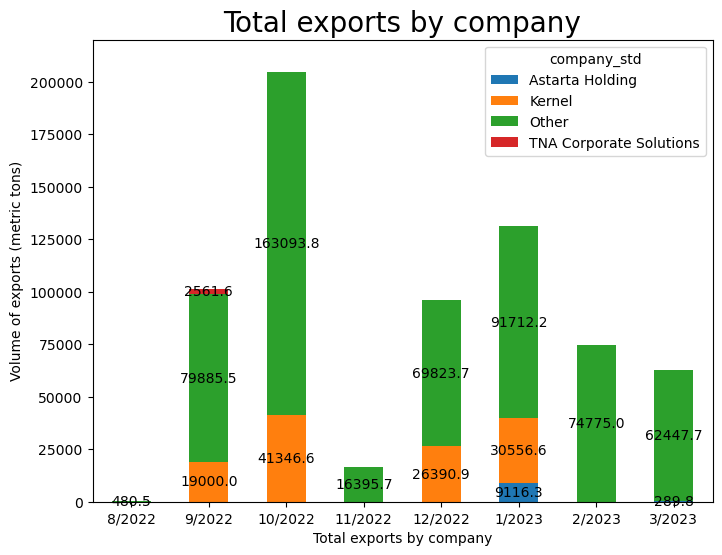

In [24]:
plot_stack_bar(pivot, "Total exports by company", "Volume of exports (metric tons)", "Total exports by company", "date", 220000)

We plot the same stacked bars but now by country

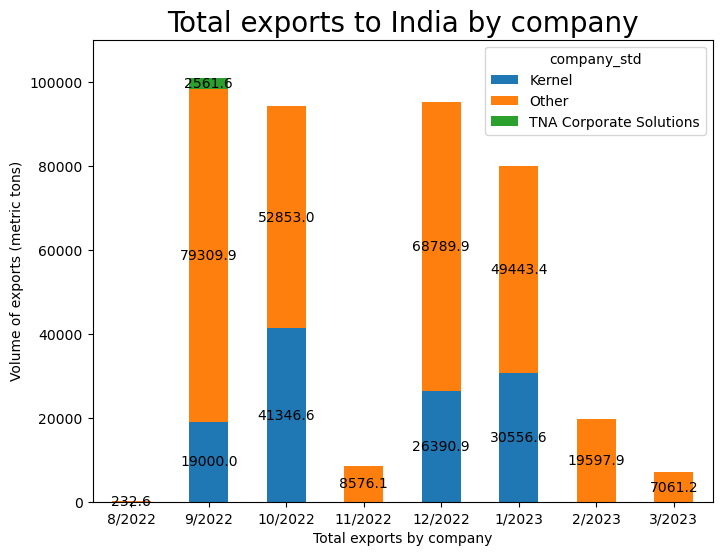

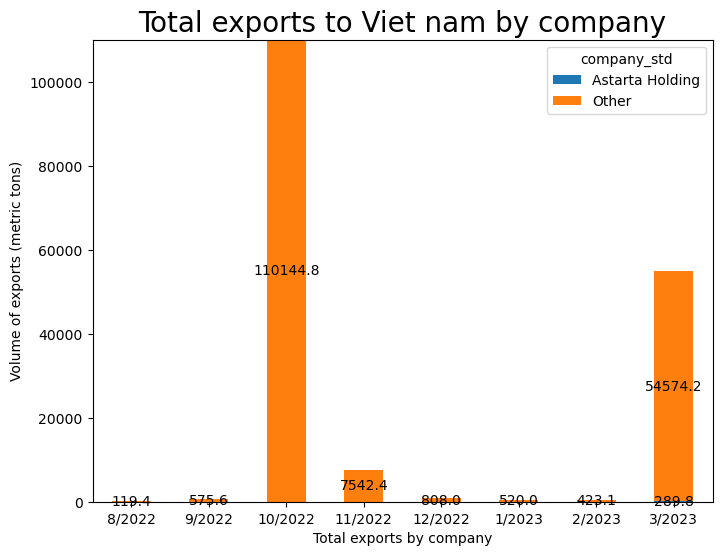

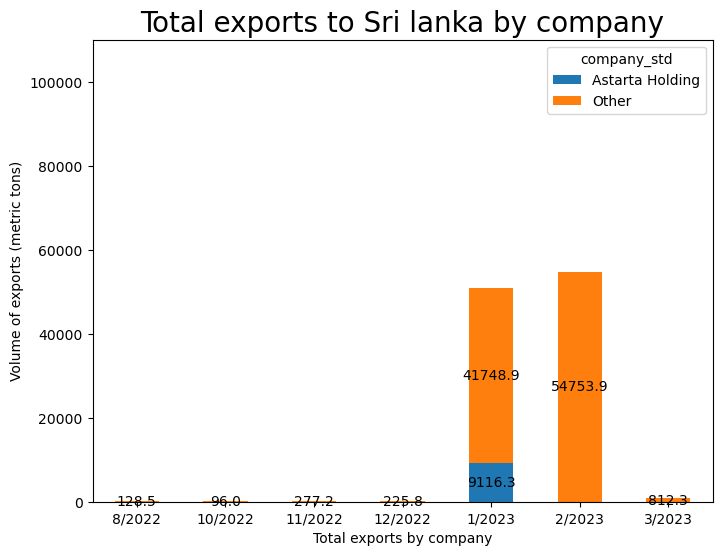

In [32]:
country_d = {"india": "індія", "viet nam": "в єтнам", "sri lanka": "шрі ланка"}

for country_en, country_uk in country_d.items():
    ig_country = ig_c[ig_c["country"] == country_uk]
    pivot_country = create_wide_table(ig_country, ["year", "month", "company_std"], ["weight_ton"], ["year", "month", "company_std"], True, {"weight_ton": "sum"})
    plot_stack_bar(pivot_country, "Total exports by company", "Volume of exports (metric tons)", f"Total exports to {country_en.capitalize()} by company", "date", 110000)

Now we get the same table but with the specific companies that are not in the top 10 disaggregated.

In [25]:
ig_c["company_all"] = ig_c["company_std"]
for idx, row in ig_c.iterrows():
    if row["company_std"] == "Other":
        ig_c["company_all"][idx] = ig_c["shipper"][idx]

/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_1248/2768725281.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig_c["company_all"][idx] = ig_c["shipper"][idx]
/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_1248/2768725281.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig_c["company_all"][idx] = ig_c["shipper"][idx]
/var/folders/j4/m2rbwhqs6yq26cq7rc0g4cm80000gn/T/ipykernel_1248/2768725281.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [26]:
ig_all_comp = cargo_grouping(ig_c, ["year", "month", "company_all"], ["weight_ton"], ["year", "month", "weight_ton"], True, {"weight_ton": "sum"})
ig_all_comp["date"] = ig_all_comp["month"].astype(str) + "/" + ig_all_comp["year"].astype(str)
ig_all_comp = ig_all_comp.sort_values(by=["year", "month", "weight_ton"], ascending=[True, True, False])
translate_column(ig_all_comp, "company_all", "google", source="uk", target="en")

In [27]:
ig_all_translate = ig_all_comp[["date", "company_all", "company_all_gt", "weight_ton"]]
ig_all_translate.to_csv('../data/total_exports_by_company.csv', index=False)
ig_all_translate[ig_all_translate["date"] == "10/2022"]

,date,company_all,company_all_gt,weight_ton
39,10/2022,Kernel,Kernel,41346.619
64,10/2022,ТОВ ЕЙЧ ЕС ЕЙРЛАЙНС 65039 ОДЕСЬКА ОБЛ М ОДЕСА ...,HEC AIRLINES LLC 65039 ODESKA REGION Odesa VUL...,21151.790
67,10/2022,ТОВ КАТЕРИНОПІЛЬСЬКИЙ ЕЛЕВАТОР 20505 ЧЕРКАСЬКА...,KATERINOPILSK ELEVATOR LTD. 20505 CHERKASK REG...,9660.518
136,10/2022,ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ СМАРТС...,SMARTSYSTEMS LIMITED LIABILITY COMPANY 54003 M...,9155.761
43,10/2022,ПП КАРЛА МАРКСА 2 41543 СУМСЬКА ОБЛ КОНОТОПСЬК...,PP KARL MARKS 2 41543 SUMSKA REGION KONOTOPSKY...,8742.430
...,...,...,...,...
68,10/2022,ТОВ ККС 68000 ОДЕСЬКА ОБЛ М ЧОРНОМОРСЬК ВУЛИЦЯ...,LLC KKS 68000 ODESKA OBL M CHORNOMORSK STREET ...,40.270
70,10/2022,ТОВ КОМОРІТІ 65080 ОДЕСЬКА ОБЛ М ОДЕСА ЛЮСТДОР...,KOMORITI LLC 65080 Odesa REGION Odesa LYUSTDOR...,30.230
84,10/2022,ТОВ ОРАТІВЛАТІНВЕСТ 22653 ВІННИЦЬКА ОБЛ ОРАТІВ...,ORATIVLATINVEST LLC 22653 Vinnytsia Oblast ORA...,25.429
85,10/2022,ТОВ ПАЛЬМІРА ГРУП УКРАЇНА 67542 ОДЕСЬКА ОБЛ ЛИ...,LLC PALMYRA GROUP UKRAINE 67542 ODESKA REGION ...,24.411


We do some analysis to see why we have differences in weights between IG and BSGI

In [ ]:
print("IG tons:",ig_asia.loc[ig_asia.loc[:, "country"] == "шрі ланка"]["weight_ton"].sum())
print("BSGI tons:",bsgi.loc[bsgi.loc[:, "country_en"] == "sri lanka"]["weight_ton"].sum())

IG tons: 108092.31873
BSGI tons: 103768


In [ ]:
print("IG tons:",ig_asia.loc[ig_asia.loc[:, "country"] == "в єтнам"]["weight_ton"].sum())
print("BSGI tons:",bsgi.loc[bsgi.loc[:, "country_en"] == "viet nam"]["weight_ton"].sum())

IG tons: 183634.02595
BSGI tons: 168789


In [ ]:
dates = ["2022-08-01", "2022-09-01", "2022-10-01", "2022-11-01", "2022-12-01", "2023-01-01", "2023-02-01", "2023-03-01", "2023-04-01"]
ig_test = ig_asia[ig_asia["bsgi_commodity"]!= "Not in BSGI"]
for i in range(len(dates)-1):
    ig_oct = ig_test.loc[(ig_test.loc[:, "date"] >= dates[i]) & (ig_test.loc[:, "date"] < dates[i+1])]
    bsgi_oct = bsgi.loc[(bsgi.loc[:, "date"] >= dates[i]) & (bsgi.loc[:, "date"] < dates[i+1])]
    print(dates[i])
    print("IG tons:", ig_oct.loc[ig_oct.loc[:, "country"] == "в єтнам"]["weight_ton"].sum())
    print("BSGI tons:",bsgi_oct.loc[bsgi_oct.loc[:, "country_en"] == "viet nam"]["weight_ton"].sum())

2022-08-01
IG tons: 119.36
BSGI tons: 0
2022-09-01
IG tons: 575.6
BSGI tons: 0
2022-10-01
IG tons: 110144.78000000001
BSGI tons: 116789
2022-11-01
IG tons: 7542.38
BSGI tons: 0
2022-12-01
IG tons: 808.0
BSGI tons: 0
2023-01-01
IG tons: 520.0
BSGI tons: 0
2023-02-01
IG tons: 423.11359999999996
BSGI tons: 0
2023-03-01
IG tons: 54864.04
BSGI tons: 52000


In [ ]:
bsgi.loc[(bsgi.loc[:, "date"] >= "2022-10-01") & (bsgi.loc[:, "date"] < "2022-11-01") & (bsgi.loc[:, "country_en"] == "viet nam")]

,status,,vessel_name,imo,departure_port,country_en,product,weight_ton,date,inspection_cleared,...,un_region,development_category,wfp,stranded,year,month,product_std,hs_code,product_std_gt,country
673,Outbound,421,SSI CHALLENGER,9284300,Chornomorsk,germany,corn,49000,2022-10-31,8-Nov-2022,...,Western Europe and Others,developed,NaN,NaN,2022,10,corn,1005,кукурудза,німеччина
674,Outbound,420,MOUNT BAKER,9266918,Yuzhny/Pivdennyi,spain,corn,31635,2022-10-31,25-Nov-2022,...,Western Europe and Others,developed,NaN,NaN,2022,10,corn,1005,кукурудза,іспанія
675,Outbound,419,KARAMEL,9316921,Odesa,libya,corn,33000,2022-10-31,11-Nov-2022,...,Africa,developing,NaN,NaN,2022,10,corn,1005,кукурудза,лівія
676,Outbound,418,CARAVOS HARMONY,9595589,Chornomorsk,china,barley,36850,2022-10-31,2-Nov-2022,...,Asia-Pacific,developing,NaN,NaN,2022,10,barley,1003,ячмінь,китай
680,Outbound,415,SK FRIENDSHIP,8909446,Chornomorsk,egypt,soya beans,6600,2022-10-30,10-Nov-2022,...,Africa,developing,NaN,NaN,2022,10,soya,1201,соя,єгипет
681,Outbound,414,SEALOCK,8218380,Chornomorsk,türkiye,peas,2050,2022-10-30,3-Nov-2022,...,Asia-Pacific,developing,NaN,NaN,2022,10,peas,0713,горох,турецька
685,Outbound,410,AFRICAN ROBIN,9317767,Odesa,algeria,wheat,30500,2022-10-30,9-Nov-2022,...,Africa,developing,NaN,NaN,2022,10,wheat,1001,пшениця,алжир
687,Outbound +,409,ST SOFIA,9799630,Odesa,spain,barley,11000,2022-10-29,2-Nov-2022,...,Western Europe and Others,developed,NaN,NaN,2022,10,barley,1003,ячмінь,іспанія
688,Outbound,408,RUBYMAR,9138898,Yuzhny/Pivdennyi,türkiye,corn,29600,2022-10-29,1-Nov-2022,...,Asia-Pacific,developing,NaN,NaN,2022,10,corn,1005,кукурудза,турецька
690,Outbound,406,CAPTAIN ADAM 1,8914087,Chornomorsk,italy,soya beans,6600,2022-10-29,1-Nov-2022,...,Western Europe and Others,developed,NaN,NaN,2022,10,soya,1201,соя,італія


In [ ]:
ig_test.loc[(ig_test.loc[:, "date"] >= "2023-02-01") & (ig_test.loc[:, "date"] < "2023-03-01") & (ig_test.loc[:, "country"] == "в єтнам")]["product"].iloc[0]

'макуха та інші тверді відходи і залишки, одержані під час добування рослинних жирів і олій, за винятком відходів товарної позиції 2304 або 2305, мелені або немелені, негранульовані або гранульовані: - з насіння соняшнику'

In [ ]:
HS_DICT = {"1205": "Rapeseed", "2306": "Rapeseed meal", "1514": "Canola",
           "1005": "Corn", "1512": "Sunflower oil", "1206": "Sunflower seed",
            "2306": "Sunflower pellets", "2306": "Sunflower meal",
          "1001":  "Wheat", "1201": "Soya beans", "1507": "Soya oil",
          "1003":  "Barley", "0713": "Peas", "1516": "Vegetable oil",
           "2302": "Wheat bran pellets", "2302": "Sugar beet pellets"}

ig_asia["hs_code_2"] = ig_asia["hs_code"].str[:4]

ig_asia["bsgi_commodity"] = ig_asia["hs_code_2"].apply(lambda x: HS_DICT[x] if x in HS_DICT else "Not in BSGI")

ig_test = ig_asia[ig_asia["bsgi_commodity"]!= "Not in BSGI"]

print("IG tons:",ig_test.loc[ig_test.loc[:, "country"] == "в єтнам"]["weight_ton"].sum())
print("BSGI tons:",bsgi.loc[bsgi.loc[:, "country_en"] == "viet nam"]["weight_ton"].sum())


IG tons: 174997.27360000001
BSGI tons: 168789


In [ ]:
df

,shipper,weight_ton
286,Other,166495.89941
105,ТОВ Д ТРЕЙДІНГ 04119 М КИЇВ ВУЛИЦЯ ХОХЛОВИХ СІ...,58324.20000
125,ТОВ КЕРНЕЛ ТРЕЙД 01001 М КИЇВ ПРОВУЛ ТАРАСА ШЕ...,48000.00000
128,ТОВ КЕРНЕЛ ТРЕЙД 01001 МІСТО КИЇВ ПРОВУЛОК ШЕВ...,42895.42000
27,ПІДПРИЄМСТВО З ІНОЗЕМНИМИ ІНВЕСТИЦІЯМИ ВАЙТЕРР...,23874.42000
...,...,...
150,ТОВ НВП ЄНАМІН 02094 М КИЇВ ВУЛ ЧЕРВОНОТКАЦЬКА 78,0.00005
283,ФОП САМОЙЛОВ АНТОН ВОЛОДИМИРОВИЧ П Т СО167208 ...,0.00004
220,ТОВ ХІМІЧНА КОМПАНІЯ СПОЛУКА 01042 КИЇВ Б Р ДР...,0.00000
149,ТОВ НВП ЄНАМІН 02094 М КИЇВ ВУЛ ЧЕВОНОТКАЦЬКА 78,0.00000
